In [56]:
using Optim, LsqFit
using Plots, LaTeXStrings
using DelimitedFiles
using Statistics
using DataFrames
using Printf

In [2]:
ENV["COLUMNS"]=120
figdir = "figures/";

In [3]:
function print_fit_values(fit, par0, par_names)
    println(@sprintf "RSS = %.5f" fit.minimum )
    println(@sprintf "  estimate (initial estimate)")
    for i in 1:length(par0)
        name = par_names[i]
        val = fit.minimizer[i]
        p0 = par0[i]
        println(@sprintf "  %s = %.3e (%.3e)" name val p0)
    end
end

print_fit_values (generic function with 1 method)

# Viral load data fitting

Data for influenza from

*Smith, A. P., Moquin, D. J., Bernhauerova, V., & Smith, A. M. (2018). Influenza virus infection model with density dependence supports biphasic viral decay. Frontiers in Microbiology, 9(JUL), 1–10. https://doi.org/10.3389/fmicb.2018.01554*


## Data set

10 mice with 13 data points each

In [4]:
tdata = Array(range(0., 12. , step=1.0))
data = readdlm("../../data/Smith2018/Virus_Best10.txt", ' ', Float64, '\n')
DataFrame(data, Symbol.(0.:12.))

,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,0.0,4.18551,5.67816,6.00515,5.9364,5.97712,5.44716,5.19848,4.00515,0.0,0.0,0.0,0.0
2,0.0,3.99136,5.47712,5.84488,5.82436,5.81012,5.0874,4.49136,0.0,0.0,0.0,0.0,0.0
3,0.0,3.49136,5.44716,5.81012,5.83815,5.78016,5.2954,5.01851,2.94716,0.0,0.0,0.0,0.0
4,0.0,3.29788,5.77233,6.24612,5.49136,5.9624,5.14412,5.51851,3.23882,0.0,0.0,0.0,0.0
5,0.0,4.75515,5.9624,6.44716,5.78016,5.83244,5.99136,4.96982,0.0,0.0,0.0,0.0,0.0
6,0.0,4.30151,5.49136,6.86448,5.70812,5.80282,4.9624,4.47712,0.0,0.0,0.0,0.0,0.0
7,0.0,3.49136,5.7954,5.74951,6.03148,5.82436,5.2954,5.17215,3.26036,0.0,0.0,0.0,0.0
8,0.0,4.00515,6.03148,5.83815,6.26036,6.1294,5.18551,4.83815,0.0,0.0,0.0,0.0,0.0
9,0.0,3.49136,6.18551,5.78784,5.59921,5.97712,5.34488,5.47712,0.0,0.0,0.0,0.0,0.0


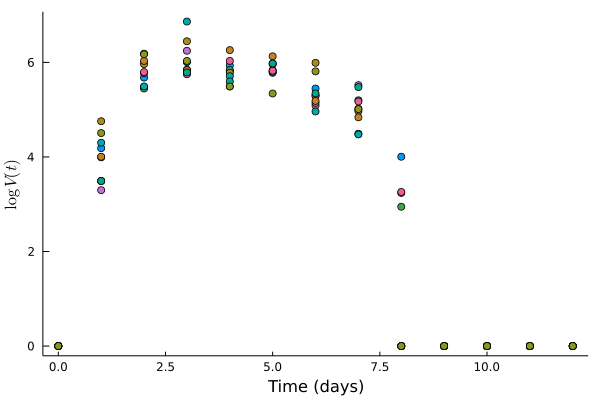

In [5]:
plt = plot(legend=:none, grid=:none, xlabel="Time (days)", ylabel=L"\log\,V(t)")
[plot!(tdata, data[i, :], seriestype=:scatter) for i in 1:size(data, 1)]
plt

### Using combined data

In [6]:
ttdata = repeat(tdata, inner=10)
tend = ttdata[end]
vvdata = reshape(data, 1, :)[:];

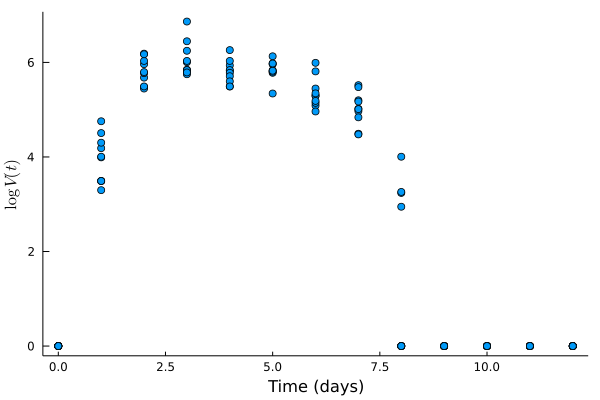

In [7]:
plot(ttdata, vvdata, 
    seriestype=:scatter, legend=:none, grid=:none,
    xlabel="Time (days)", ylabel=L"\log\,V(t)")

## Standard virus load function

Consider a virus load function with three main phases given by

$$V(t)=v_1(t)v_2(t)v_3(t),$$

where $v _1$ describes the initial growth phase between $a _1$ and $a _2$ , $v _2$ the intermediate slow decay
phase between $a _2$ and $b _1$, and $v _3$ the final decay phase between $b _1$ and $b _2$. These functions are given as sigmoid and exponential functions, respectively

$$
\begin{aligned}
v_1(t) & = 1 + \frac{V_{\max} - 1}{2} \left[ \tanh \left( \frac{6}{a_2 - a_1} \left( t - \frac{a_1 + a_2}{2} \right) \right) - \tanh  \left( -3\frac{a_2 + a_1}{a_2 - a_1} \right) \right] \\
v_2(t) & = (1 - H(t - a_2)) + H(t - a_2)e^{-\alpha(t - a_2)} \\
v_3(t) & = 1 - \frac{1 - V_{\min}}{2} \left[ \tanh \left( \frac{6}{b_2 - b_1} \left( t - \frac{b_1 + b_2}{2} \right) \right) - \tanh  \left( -3\frac{b_2 + b_1}{b_2 - b_1} \right) \right],
\end{aligned}
$$

where $H(t)$ denotes the Heaviside function.

### Chanlenges fitting this function

- The parameter $V_{\min}$ is particularly difficult to deal with because is smaller than reasonable steps length, causing $v_3(t)$ to become negative.

  Solutions to this problem:

  - Fix the value of $V_{\min}$.
  - Rescale $V_{\min}$, i.e., $V_{\min} = 10^{\tilde V_{\min}}$. **Implemented here.**
  - Restrict the step length, but convergence would take much longer. This could be done via `LineSearches.jl`.

- A similar issue occurs with $V_{\max}$, the scale is this parameter is very large compared to the rest.
  
  Solutions to this problem:
  
  - Fix the value of $V_{\max}$.
  - Rescale $V_{\max}$, i.e., $V_{\max} = 10^{\tilde V_{\min}}$. **Implemented here.**
  - Include weights. This could be done via `LsqFit.jl`

- The initial guess and lower and upper bounds are tricky to choose. First, because far from initial conditions we could have violation of $a_1<a_2<b_1<b_2$, hence negative $V(t)$; and second, if we impose bounds forcing this condition it is easy to hit the bounds when optimizing.

- Standard error are sometime large.

- Data usually has a threshold of bwloe which all counts are given the same value. For example, points equal to $0$ from time $t=8$ to $t=12$ in the sata set above.

**Using the rescaling $V_{\min}$ and $V_{\max}$ seems to be the better solution for the first three problems above.**

**Forcing the function to be equal to a threshold $\theta$ when the value of the function drops below that value. For that we define the empirical virus load function.**

$$
L V_{\theta}(t) = \max( \log V(t), \theta).
$$

In [8]:
H(x::AbstractFloat) = ifelse(x < 0, zero(x), ifelse(x > 0, one(x), oftype(x,0.5)))
function v₁(t, a₁, a₂, logVmax)
    1. + (10^logVmax - 1.0)*(tanh(6.0*(t - (a₁ + a₂)/2)/abs(a₂ - a₁)) - tanh(-3.0*(a₂ + a₁)/abs(a₂ - a₁)))/2
end
function v₂(t, a₂, α) 
    1. - H(t - a₂) + H(t - a₂)*exp(-α*(t - a₂))
end
function v₃(t, b₁, b₂, logVmin)
    1. - (1.0 - 10^logVmin)*(tanh(6.0*(t - (b₁ + b₂)/2)/abs(b₂ - b₁)) - tanh(-3.0*(b₂ + b₁)/abs(b₂ - b₁)))/2
end
function LogVirusLoad(t, p)
    θ = minimum(vvdata)
    logVmin = -6.0
    a₁, a₂, b₁, b₂, α, logVmax = p
    logV = log10.(v₁.(t, a₁, a₂, logVmax).*v₂.(t, a₂, α).*v₃.(t, b₁, b₂, logVmin))
    max.(logV, θ)
end
par_names = ["a₁", "a₂", "b₁", "b₂", "α", "logVmax"];
cost(p) = sum(LogVirusLoad(ttdata, p) - vvdata).^2

cost (generic function with 1 method)

## Optimizations methods

### Levenberg-Marquardt via `LsqFit.jl`
It is particularly hard to choose initial values and lower and upper bounds

In [9]:
#       a₁,   a₂,   b₁,   b₂,   α,    logVmax
par0 = [0.70, 2.88, 6.00, 7.60, 0.20, 5.0]
lb   = [0.00, 1.00, 5.00, 7.00, 1e-8, 4.0]
ub   = [1.00, 5.00, 7.00, 9.00, 10.0, 7.0]
fit = curve_fit(LogVirusLoad, ttdata, vvdata, par0, lower=lb, upper=ub)

LsqFit.LsqFitResult{Vector{Float64}, Vector{Float64}, Matrix{Float64}, Vector{Float64}}([0.7722333214929267, 3.1612139518627753, 6.3796823758428385, 7.726057611474353, 0.5032046701393494, 6.066867262152775], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], true, Float64[])

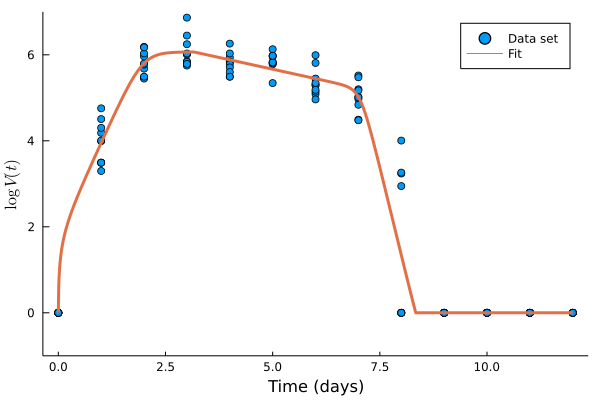

In [10]:
tt = [range(0., tend, step=1e-2);]
vv = LogVirusLoad(tt, fit.param)
pt = plot(ttdata, vvdata, 
    label="Data set", seriestype=:scatter)
plot!(pt, tt, vv, lw=3,
    grid=:off, label="Fit",
    xaxis = ("Time (days)"),
    yaxis = (L"$\log\, V(t)$", (-1, 7)))
savefig(figdir*"Smith2018VLFDataFit.png")
savefig(figdir*"Smith2018VLFDataFit.pdf")
display(pt)

In [11]:
print_fit_values(fit, par0, par_names)

LoadError: type LsqFitResult has no field minimum

## Exploration

In the following, we try different ideas and approches.

### Box constrains with Conjugate Gradient via `Optim.jl` 
Just for the sake of comparisson, let's use anothe numerical method different to Levenberg-Marquart. In this case, we use interior points with Conjugate Gradient which does not require first derivative information. (Note that the empirical virus load function is not differentiable with repec to the parameters since it involves the maximum functions.)

In [12]:
cost(p) = sum(abs2, LogVirusLoad(ttdata, p) - vvdata)

cost (generic function with 1 method)

Convergence is faster and appears to be slightly better (smaller RSS) that with the previous method.

In [13]:
#       a₁,   a₂,   b₁,   b₂,   α,    logVmax
par0 = [0.10, 2.88, 6.00, 7.60, 0.20, 5.0]
lb   = [0.00, 1.00, 5.00, 7.00, 1e-8, 4.0]
ub   = [1.00, 5.00, 7.00, 9.00, 10.0, 7.0]
fit2 = optimize(cost, lb, ub, par0, SAMIN(), Optim.Options(iterations=10^5))

SAMIN results
==> Normal convergence <==
total number of objective function evaluations: 53101

     Obj. value:     35.2616862604

       parameter      search width
         0.77223           0.00000 
         3.16121           0.00000 
         6.37968           0.00000 
         7.72606           0.00000 
         0.50320           0.00000 
         6.06687           0.00000 



 * Status: failure

 * Candidate solution
    Final objective value:     3.526169e+01

 * Found with
    Algorithm:     SAMIN

 * Convergence measures
    |x - x'|               = NaN ≰ 0.0e+00
    |x - x'|/|x'|          = NaN ≰ 0.0e+00
    |f(x) - f(x')|         = NaN ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = NaN ≰ 0.0e+00
    |g(x)|                 = NaN ≰ 0.0e+00

 * Work counters
    Seconds run:   3  (vs limit Inf)
    Iterations:    53101
    f(x) calls:    53101
    ∇f(x) calls:   0


In [14]:
#       a₁,   a₂,   b₁,   b₂,   α,    logVmax
par0 = [0.70, 2.88, 6.00, 7.60, 0.20, 5.0]
lb   = [0.00, 1.00, 5.00, 7.00, 1e-8, 4.0]
ub   = [1.00, 5.00, 7.00, 9.00, 10.0, 7.0]
fit2 = optimize(cost, lb, ub, par0, ParticleSwarm(), Optim.Options(iterations=10^4))

 * Status: failure (reached maximum number of iterations)

 * Candidate solution
    Final objective value:     3.619234e+01

 * Found with
    Algorithm:     Particle Swarm

 * Convergence measures
    |x - x'|               = NaN ≰ 0.0e+00
    |x - x'|/|x'|          = NaN ≰ 0.0e+00
    |f(x) - f(x')|         = NaN ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = NaN ≰ 0.0e+00
    |g(x)|                 = NaN ≰ 1.0e-08

 * Work counters
    Seconds run:   2  (vs limit Inf)
    Iterations:    10000
    f(x) calls:    70006
    ∇f(x) calls:   0


In [15]:
fit2.minimum

36.19233743434198

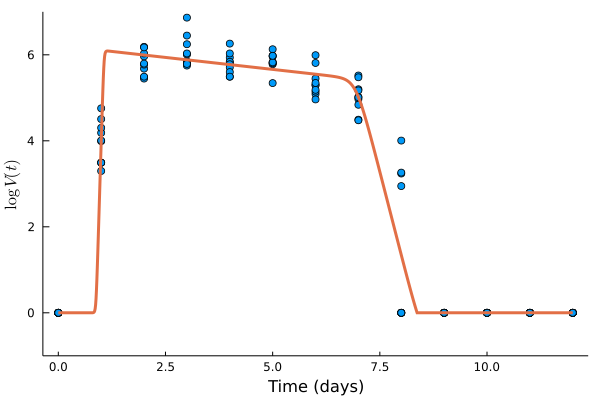

In [16]:
tt = [range(0., tend, step=1e-2);]
vv = LogVirusLoad(tt, Optim.minimizer(fit2))
plot(ttdata, vvdata, seriestype=:scatter)
plot!(tt, vv, lw=3,
    legend=:none, grid=:off,
    xaxis = ("Time (days)"),
    yaxis = (L"$\log\, V(t)$", (-1, 7)))

Same optimizer as before.

In [17]:
Optim.minimizer(fit2)

6-element Vector{Float64}:
 0.9855358088606533
 1.1457833047356587
 6.252796749735015
 7.634379593525522
 0.25655137966167385
 6.090096308158417

However, the package `Optim.jl` does not provide with standard error. They have to be computed separately.

### Combined data without the last three observations

All observation equal to zero (the threshold $\theta$ for this data set) represent any measurement below the threshold. Thus, increasing or decreasing the number of observations below the threshold should not affect the best fit. this time we'll remove the last three observations.

In [18]:
ttdata = repeat(tdata[1:end-3], inner=10)
tend = ttdata[end]
vvdata = reshape(data[:, 1:end-3], 1, :)[:];

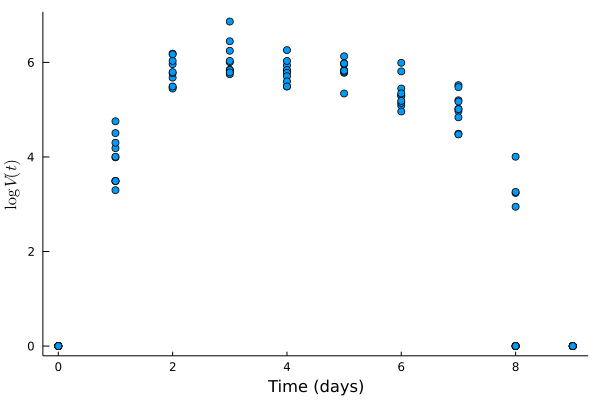

In [19]:
plot(ttdata, vvdata, 
    seriestype=:scatter, legend=:none, grid=:none,
    xaxis=("Time (days)"), yaxis=(L"\log\,V(t)"))

Same initial conditions as in the first case

In [20]:
#       a₁,   a₂,   b₁,   b₂,   α,    logVmax
par0 = [0.70, 2.88, 6.00, 7.60, 0.20, 5.0]
lb   = [0.00, 1.00, 5.00, 7.00, 1e-8, 4.0]
ub   = [1.00, 5.00, 7.00, 9.00, 10.0, 7.0]
fit = optimize(cost, lb, ub, par0, SAMIN(), Optim.Options(iterations=10^5))

SAMIN results
==> Normal convergence <==
total number of objective function evaluations: 50851

     Obj. value:     35.2616862604

       parameter      search width
         0.77223           0.00000 
         3.16121           0.00000 
         6.37968           0.00000 
         7.72606           0.00000 
         0.50320           0.00000 
         6.06687           0.00000 



 * Status: failure

 * Candidate solution
    Final objective value:     3.526169e+01

 * Found with
    Algorithm:     SAMIN

 * Convergence measures
    |x - x'|               = NaN ≰ 0.0e+00
    |x - x'|/|x'|          = NaN ≰ 0.0e+00
    |f(x) - f(x')|         = NaN ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = NaN ≰ 0.0e+00
    |g(x)|                 = NaN ≰ 0.0e+00

 * Work counters
    Seconds run:   1  (vs limit Inf)
    Iterations:    50851
    f(x) calls:    50851
    ∇f(x) calls:   0


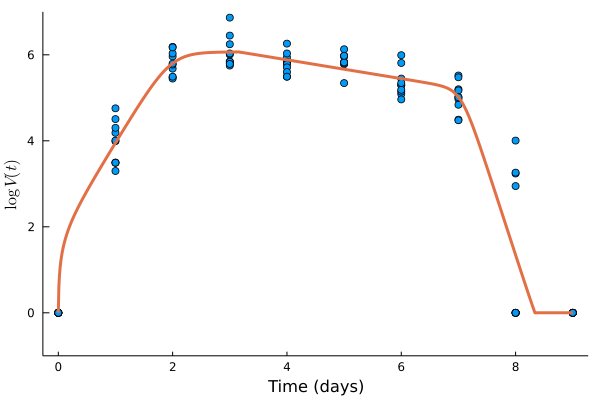

In [21]:
tt = [range(0., tend, step=1e-2);]
vv = LogVirusLoad(tt, fit.minimizer)
plot(ttdata, vvdata, seriestype=:scatter)
plot!(tt, vv, lw=3,
    legend=:none, grid=:off,
    xaxis = ("Time (days)"),
    yaxis = (L"$\log\, V(t)$", (-1, 7)))

In [22]:
print_fit_values(fit, par0, par_names)

RSS = 35.26169
  estimate (initial estimate)
  a₁ = 7.722e-01 (7.000e-01)
  a₂ = 3.161e+00 (2.880e+00)
  b₁ = 6.380e+00 (6.000e+00)
  b₂ = 7.726e+00 (7.600e+00)
  α = 5.032e-01 (2.000e-01)
  logVmax = 6.067e+00 (5.000e+00)


This is the same best fit as before.
```
RSS = 35.26169
  estimate (initial estimate)
  a₁ = 7.722e-01 (7.000e-01)
  a₂ = 3.161e+00 (2.880e+00)
  b₁ = 6.380e+00 (6.000e+00)
  b₂ = 7.726e+00 (7.600e+00)
  α = 5.032e-01 (2.000e-01)
  logVmax = 6.067e+00 (5.000e+00)
```

## Changing the value of $V_{min}$

Does the choice of $V_{min}$ effect the best fit? For this, we redefine the function and try different values $V_{min}=-4$, $-10$,  and $-14$.

In [23]:
ttdata = repeat(tdata, inner=10)
tend = ttdata[end]
vvdata = reshape(data, 1, :)[:];

SAMIN results


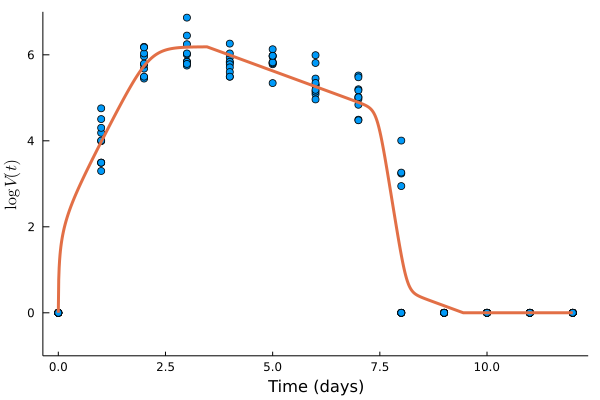

==> WARNING <==
Last point satisfies convergence criteria, but is near
boundary of parameter space.
4 out of  150 evaluations were out of bounds in the last round.
Expand bounds and re-run, unless this is a constrained minimization.
total number of objective function evaluations: 52051

     Obj. value:     36.3293029519

       parameter      search width
         0.79332           0.00000 
         3.46960           0.00000 
         7.00000           0.00000 
         7.88907           0.00000 
         0.84212           0.00000 
         6.18633           0.00000 

RSS = 36.32930
  estimate (initial estimate)
  a₁ = 7.933e-01 (7.000e-01)
  a₂ = 3.470e+00 (2.880e+00)
  b₁ = 7.000e+00 (6.000e+00)
  b₂ = 7.889e+00 (7.600e+00)
  α = 8.421e-01 (2.000e-01)
  logVmax = 6.186e+00 (5.000e+00)


In [24]:
function LogVirusLoad(t, p)
    θ = minimum(vvdata)
    logVmin = -4.0
    a₁, a₂, b₁, b₂, α, logVmax = p
    logV = log10.(v₁.(t, a₁, a₂, logVmax).*v₂.(t, a₂, α).*v₃.(t, b₁, b₂, logVmin))
    max.(logV, θ)
end
par0 = [0.70, 2.88, 6.00, 7.60, 0.20, 5.0]
lb   = [0.00, 1.00, 5.00, 7.00, 1e-8, 4.0]
ub   = [1.00, 5.00, 7.00, 9.00, 10.0, 7.0]
fit = optimize(cost, lb, ub, par0, SAMIN(), Optim.Options(iterations=10^5))
tt = [range(0., tend, step=1e-2);]
vv = LogVirusLoad(tt, fit.minimizer)
pt = plot(ttdata, vvdata, seriestype=:scatter)
plot!(pt, tt, vv, lw=3,
    legend=:none, grid=:off,
    xaxis = ("Time (days)"),
    yaxis = (L"$\log\, V(t)$", (-1, 7)))
display(pt)
print_fit_values(fit, par0, par_names)

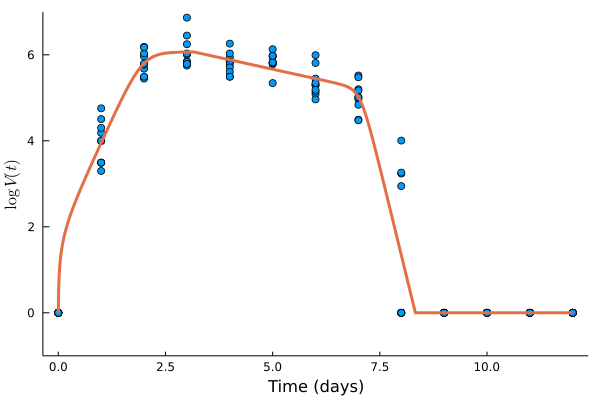

SAMIN results
==> Normal convergence <==
total number of objective function evaluations: 52201

     Obj. value:     35.2616859559

       parameter      search width
         0.77223           0.00000 
         3.16121           0.00000 
         6.37936           0.00000 
         7.72643           0.00000 
         0.50320           0.00000 
         6.06687           0.00000 

RSS = 35.26169
  estimate (initial estimate)
  a₁ = 7.722e-01 (7.000e-01)
  a₂ = 3.161e+00 (2.880e+00)
  b₁ = 6.379e+00 (6.000e+00)
  b₂ = 7.726e+00 (7.600e+00)
  α = 5.032e-01 (2.000e-01)
  logVmax = 6.067e+00 (5.000e+00)


In [25]:
function LogVirusLoad(t, p)
    θ = minimum(vvdata)
    logVmin = -10.0
    a₁, a₂, b₁, b₂, α, logVmax = p
    logV = log10.(v₁.(t, a₁, a₂, logVmax).*v₂.(t, a₂, α).*v₃.(t, b₁, b₂, logVmin))
    max.(logV, θ)
end
par0 = [0.70, 2.88, 6.00, 7.60, 0.20, 5.0]
lb   = [0.00, 1.00, 5.00, 7.00, 1e-8, 4.0]
ub   = [1.00, 5.00, 7.00, 9.00, 10.0, 7.0]
fit = optimize(cost, lb, ub, par0, SAMIN(), Optim.Options(iterations=10^5))
tt = [range(0., tend, step=1e-2);]
vv = LogVirusLoad(tt, fit.minimizer)
pt = plot(ttdata, vvdata, seriestype=:scatter)
plot!(pt, tt, vv, lw=3,
    legend=:none, grid=:off,
    xaxis = ("Time (days)"),
    yaxis = (L"$\log\, V(t)$", (-1, 7)))
display(pt)
print_fit_values(fit, par0, par_names)

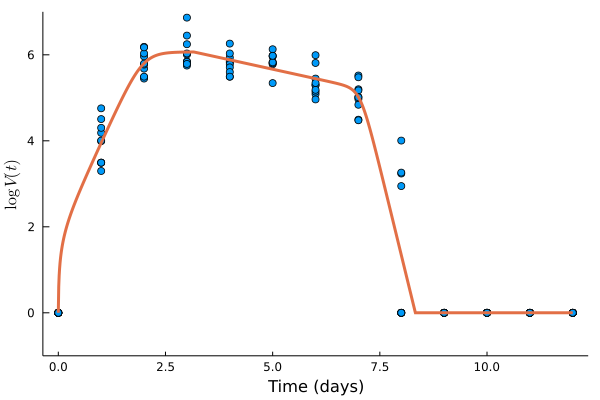

SAMIN results
==> Normal convergence <==
total number of objective function evaluations: 51751

     Obj. value:     35.2616859559

       parameter      search width
         0.77223           0.00000 
         3.16121           0.00000 
         6.37936           0.00000 
         7.72643           0.00000 
         0.50320           0.00000 
         6.06687           0.00000 

RSS = 35.26169
  estimate (initial estimate)
  a₁ = 7.722e-01 (7.000e-01)
  a₂ = 3.161e+00 (2.880e+00)
  b₁ = 6.379e+00 (6.000e+00)
  b₂ = 7.726e+00 (7.600e+00)
  α = 5.032e-01 (2.000e-01)
  logVmax = 6.067e+00 (5.000e+00)


In [26]:
function LogVirusLoad(t, p)
    θ = minimum(vvdata)
    logVmin = -14.0
    a₁, a₂, b₁, b₂, α, logVmax = p
    logV = log10.(v₁.(t, a₁, a₂, logVmax).*v₂.(t, a₂, α).*v₃.(t, b₁, b₂, logVmin))
    max.(logV, θ)
end
par0 = [0.70, 2.88, 6.00, 7.60, 0.20, 5.0]
lb   = [0.00, 1.00, 5.00, 7.00, 1e-8, 4.0]
ub   = [1.00, 5.00, 7.00, 9.00, 10.0, 7.0]
fit = optimize(cost, lb, ub, par0, SAMIN(), Optim.Options(iterations=10^5))
tt = [range(0., tend, step=1e-2);]
vv = LogVirusLoad(tt, fit.minimizer)
pt = plot(ttdata, vvdata, seriestype=:scatter)
plot!(pt, tt, vv, lw=3,
    legend=:none, grid=:off,
    xaxis = ("Time (days)"),
    yaxis = (L"$\log\, V(t)$", (-1, 7)))
display(pt)
print_fit_values(fit, par0, par_names)

Compare these results with the original best fit
```
RSS = 35.26169 (convergence: true)
  a₁ = 7.722e-01 (CI=(5.427e-01, 1.002e+00), initial=7.000e-01)
  a₂ = 3.161e+00 (CI=(2.411e+00, 3.912e+00), initial=2.880e+00)
  b₁ = 6.380e+00 (CI=(5.845e+00, 6.914e+00), initial=6.000e+00)
  b₂ = 7.726e+00 (CI=(7.509e+00, 7.943e+00), initial=7.600e+00)
  α = 5.032e-01 (CI=(8.278e-02, 9.236e-01), initial=2.000e-01)
  logVmax = 6.067e+00 (CI=(5.817e+00, 6.316e+00), initial=5.000e+00)
```
For $\log V_{min}=-4$ the fit is not good, but for $\log V_{min}<-6$ the fit is basically the same.

## Non-empirical Virus Load Function

Now let's use the virus load function without taking into account the threshold, that is without forcing the maximum value between the function and the threshold.

With all data points. The value of $\alpha$ is too small.

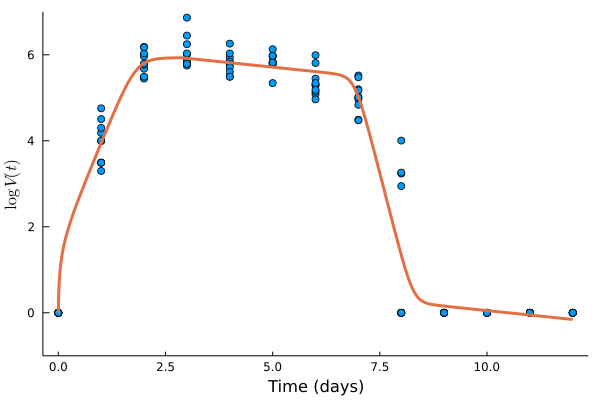

SAMIN results
==> Normal convergence <==
total number of objective function evaluations: 64751

     Obj. value:     36.3423711495

       parameter      search width
         0.74054           0.00000 
         2.88199           0.00000 
         6.22581           0.00000 
         7.60562           0.00000 
         0.23801           0.00000 
        -5.14456           0.00000 
         5.93191           0.00000 

RSS = 36.34237
  estimate (initial estimate)
  a₁ = 7.405e-01 (7.000e-01)
  a₂ = 2.882e+00 (2.880e+00)
  b₁ = 6.226e+00 (6.000e+00)
  b₂ = 7.606e+00 (7.600e+00)
  α = 2.380e-01 (2.000e-01)
  logVmin = -5.145e+00 (-6.000e+00)
  logVmax = 5.932e+00 (5.000e+00)


In [27]:
function LogVirusLoad(t, p)
    a₁, a₂, b₁, b₂, α, logVmin, logVmax = p
    log10.(v₁.(t, a₁, a₂, logVmax).*v₂.(t, a₂, α).*v₃.(t, b₁, b₂, logVmin))
end
par_names = ["a₁", "a₂", "b₁", "b₂", "α", "logVmin", "logVmax"];
par0 = [0.70, 2.88, 6.00, 7.60, 0.20, -6.00, 5.0]
lb   = [0.00, 1.00, 5.00, 7.00, 1e-8, -12.0, 4.0]
ub   = [1.00, 5.00, 7.00, 9.00, 10.0, -2.00, 7.0]
fit = optimize(cost, lb, ub, par0, SAMIN(), Optim.Options(iterations=10^5))
tt = [range(0., tend, step=1e-2);]
vv = LogVirusLoad(tt, fit.minimizer)
pt = plot(ttdata, vvdata, seriestype=:scatter)
plot!(pt, tt, vv, lw=3,
    legend=:none, grid=:off,
    xaxis = ("Time (days)"),
    yaxis = (L"$\log\, V(t)$", (-1, 7)))
display(pt)
print_fit_values(fit, par0, par_names)

Now removing the last three observations. The result is the same as in the case of empirical virus load function.

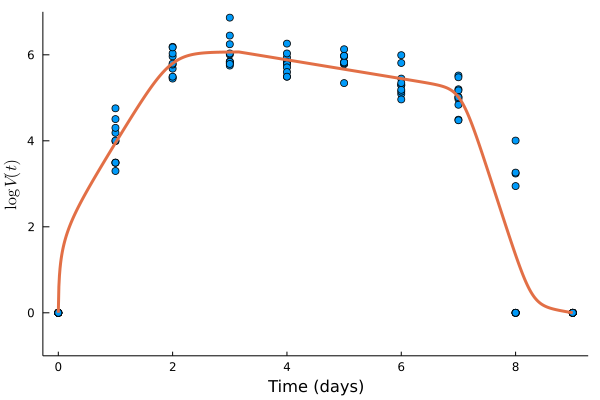

SAMIN results
==> Normal convergence <==
total number of objective function evaluations: 65101

     Obj. value:     35.2616908773

       parameter      search width
         0.77223           0.00000 
         3.16122           0.00000 
         6.38472           0.00000 
         7.72017           0.00000 
         0.50321           0.00000 
        -4.79151           0.00000 
         6.06687           0.00000 

RSS = 35.26169
  estimate (initial estimate)
  a₁ = 7.722e-01 (7.000e-01)
  a₂ = 3.161e+00 (2.880e+00)
  b₁ = 6.385e+00 (6.000e+00)
  b₂ = 7.720e+00 (7.600e+00)
  α = 5.032e-01 (2.000e-01)
  logVmin = -4.792e+00 (-6.000e+00)
  logVmax = 6.067e+00 (5.000e+00)


In [28]:
ttdata = repeat(tdata[1:end-3], inner=10)
tend = ttdata[end]
vvdata = reshape(data[:, 1:end-3], 1, :)[:];
fit = optimize(cost, lb, ub, par0, SAMIN(), Optim.Options(iterations=10^5))
tt = [range(0., tend, step=1e-2);]
vv = LogVirusLoad(tt, fit.minimizer)
pt = plot(ttdata, vvdata, seriestype=:scatter)
plot!(pt, tt, vv, lw=3,
    legend=:none, grid=:off,
    xaxis = ("Time (days)"),
    yaxis = (L"$\log\, V(t)$", (-1, 7)))
display(pt)
print_fit_values(fit, par0, par_names)

**As we can see,the empirical virus load function is more adequate for data.**

## Figures for the paper

In [29]:
Plots.scalefontsizes(1/1.4)

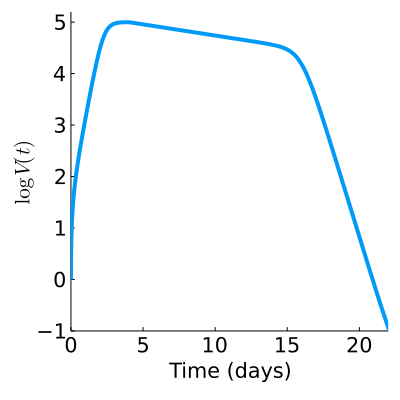

In [30]:
tend = 25.
par = [0.5,
       4.0,
       13.0,
       19.0,
       0.1,
       -6.0,
       5.0]
tt = Vector(range(0., tend, step=1e-2))
vv = LogVirusLoad(tt, par)
pt = plot(tt, vv, lw=4,
    legend=:none, grid=:off, size=(400, 400),
    xaxis = ("Time (days)", (0., 22.), font(14)),
    yaxis = (L"$\log\, V(t)$", (-1, 5.2), font(14)))
savefig("figures/VirusLoadLog.pdf")
savefig("figures/VirusLoadLog.png")
display(pt)

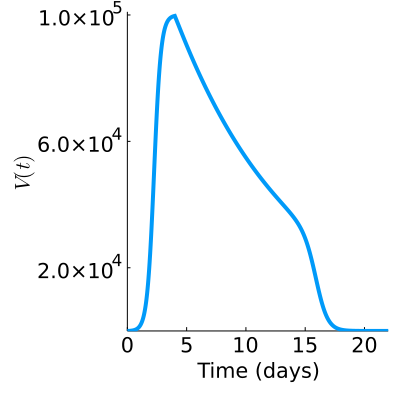

In [31]:
pt = plot(tt, 10.0.^vv, lw=4,
    legend=:none, grid=:off, size=(400, 400),
    xaxis = ("Time (days)", (0., 22.), font(14)),
    yaxis = (L"$V(t)$", (0, 1.01e5), font(14), [2e4, 6e4, 10e4]))
savefig("figures/VirusLoad.pdf")
savefig("figures/VirusLoad.png")
display(pt)

## Confidence intervals

Using MCMC

MCMCM test

In [58]:
# Note that loading Optim explicitly is required for mode estimation to function,
# as Turing does not load the opimization suite unless Optim is loaded as well.
using Turing, StatsPlots
using Optim

In [59]:
@model function gdemo(x)
    s ~ InverseGamma(2, 3)
    m ~ Normal(0, sqrt(s))

    for i in eachindex(x)
        x[i] ~ Normal(m, sqrt(s))
    end
end

gdemo (generic function with 2 methods)

In [60]:
# Create some data to pass to the model.
data = [1.5, 2.0]

# Instantiate the gdemo model with our data.
model = gdemo(data)

DynamicPPL.Model{var"#9#10", (:x,), (), (), Tuple{Vector{Float64}}, Tuple{}}(:gdemo, var"#9#10"(), (x = [1.5, 2.0],), NamedTuple())

In [68]:
# Generate a MLE estimate.
mle_estimate = optimize(model, MLE())
mle_estimate = optimize(model, MLE(), NelderMead())

ModeResult with maximized lp of -0.07
2-element Named Vector{Float64}
A  │ 
───┼──────────
:s │ 0.0624969
:m │   1.74999

In [73]:
mle_estimate.optim_result.minimizer

2-element Vector{Float64}:
 -2.7726377031403753
  1.74999271542942

In [ ]:
# Import StatsBase to use it's statistical methods.
using StatsBase

In [69]:
# Print out the coefficient table.
coeftable(mle_estimate)

MethodError: MethodError: [0mCannot `convert` an object of type [92mSymbol[39m[0m to an object of type [91mString[39m
[0mClosest candidates are:
[0m  convert(::Type{S}, [91m::CategoricalArrays.CategoricalValue[39m) where S<:Union{AbstractChar, AbstractString, Number} at /home/shigoto/.julia/packages/CategoricalArrays/MIs0G/src/value.jl:79
[0m  convert(::Type{T}, [91m::Union{InitialValues.SpecificInitialValue{typeof(*)}, InitialValues.SpecificInitialValue{typeof(Base.mul_prod)}}[39m) where T<:Union{AbstractString, Number} at /home/shigoto/.julia/packages/InitialValues/EPz1F/src/InitialValues.jl:257
[0m  convert(::Type{T}, [91m::ProgressLogging.ProgressString[39m) where T<:AbstractString at /home/shigoto/.julia/packages/ProgressLogging/6KXlp/src/ProgressLogging.jl:211
[0m  ...